In [1]:
#mixup.py
import math
import random

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras import backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Activation, Input, Dense, Conv2D, LeakyReLU
from keras.layers import Dropout, BatchNormalization, Flatten, Reshape, SpatialDropout2D


Using TensorFlow backend.


In [2]:
def _mixup_batch(in_batch: np.ndarray, out_batch: np.ndarray, alpha: int = 1.0):
    """Mixup the batch by sampling from a beta distribution and 
    computing a weighted average of the first half of the batch with last half."""
    half = in_batch.shape[0] // 2
    mixed_ins = np.zeros((half,) + in_batch.shape[1:])
    mixed_outs = np.zeros((half,) + out_batch.shape[1:])
    for i in range(half):
        weight0 = np.random.beta(alpha, alpha)
        weight1 = 1 - weight0
        mixed_ins[i] = (in_batch[i, ...] * weight0) + (in_batch[half+i, ...] * weight1)
        mixed_outs[i] = (out_batch[i, ...] * weight0) + (out_batch[half+i, ...] * weight1)
    return mixed_ins, mixed_outs



In [3]:
def load_mnist():
    img_rows, img_cols = 28, 28

    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1).astype('float32')
    x_train /= 128.0
    x_test /= 128.0
    x_train -= 1.0
    x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    print('y_train shape:', y_train.shape)
    print('y_train sum:', np.sum(y_train, axis=0))
    return (x_train, y_train), (x_test, y_test)

In [4]:
def load_cifar():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255.0
    x_test /= 255.0
    #x_train -= 1.0
    #x_test -= 1.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    print('bounds:', np.min(x_train), np.max(x_train))
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')	
    return (x_train, y_train), (x_test, y_test)

In [5]:
def _plot_batch(image_batch):
    batch_size = image_batch.shape[0]
    sqrt_batch = int(math.sqrt(batch_size))
    _, axes = plt.subplots(sqrt_batch, sqrt_batch, figsize=(18, 14))
    for i in range(batch_size):
        if image_batch.shape[-1] == 1:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, :, :, 0])
        else:
            axes[i//sqrt_batch, i%sqrt_batch].imshow(image_batch[i, ...])

In [6]:
def build_discriminative_model(in_shape, out_classes):
    d_input = Input(in_shape)
    H = Conv2D(128, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(d_input)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Conv2D(64, (3, 3), strides=(2,2), padding='same', kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    H = LeakyReLU(0.2)(H)
    H = Flatten()(H)
    H = Dense(32, kernel_regularizer=l2(0.001))(H)
    H = BatchNormalization(momentum=0.9)(H)
    d_V = Dense(out_classes, activation='softmax', kernel_regularizer=l2(0.001))(H)
    discriminator = Model(d_input, d_V)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam')
    discriminator.summary()
    return discriminator

mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [7]:
def _accuracy_on_batch(discriminator, batch, y):
    y_hat = discriminator.predict(batch)
    y_hat_idx = np.argmax(y_hat, axis=-1)
    y_idx = np.argmax(y, axis=-1)
    diff = y_idx-y_hat_idx
    n_tot = y.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print(f'y true sum:{[f"{num:0.1f}" for num in np.sum(y, axis=0)]}. Accuracy: {acc:0.02f} pct ({n_rig} of {n_tot}).')
    print(f'y pred sum:{[f"{num:0.1f}" for num in np.sum(y_hat, axis=0)]}')

11493376/11490434 [==============================] - 0s 0us/step
bounds: -1.0 0.9921875
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
y_train shape: (60000, 10)
y_train sum: [5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
y true sum:['3.0', '10.0', '6.0', '4.0', '4.0', '10.0', '8.0', '3.0', '8.0', '8.0']. Accuracy: 64.06 pct (41 of 64).
y pred sum:['9.1', '5.6', '3.9', '9.6', '4.6', '6.5', '9.1', '3.7', '3.6', '8.3']
step 0 with loss 2.7809536457061768
y true sum:['5.0', '7.0', '6.0', '8.0', '7.0', '9.0', '3.0', '5.0', '8.0', '6.0']. Accuracy: 64.06 pct (41 of 64).
y pred sum:['8.8', '8.4', '2.5', '10.0', '6.0', '3.4', '3.9', '3.7', '11.4', '5.9']
step 5 with loss 1.2993580102920532


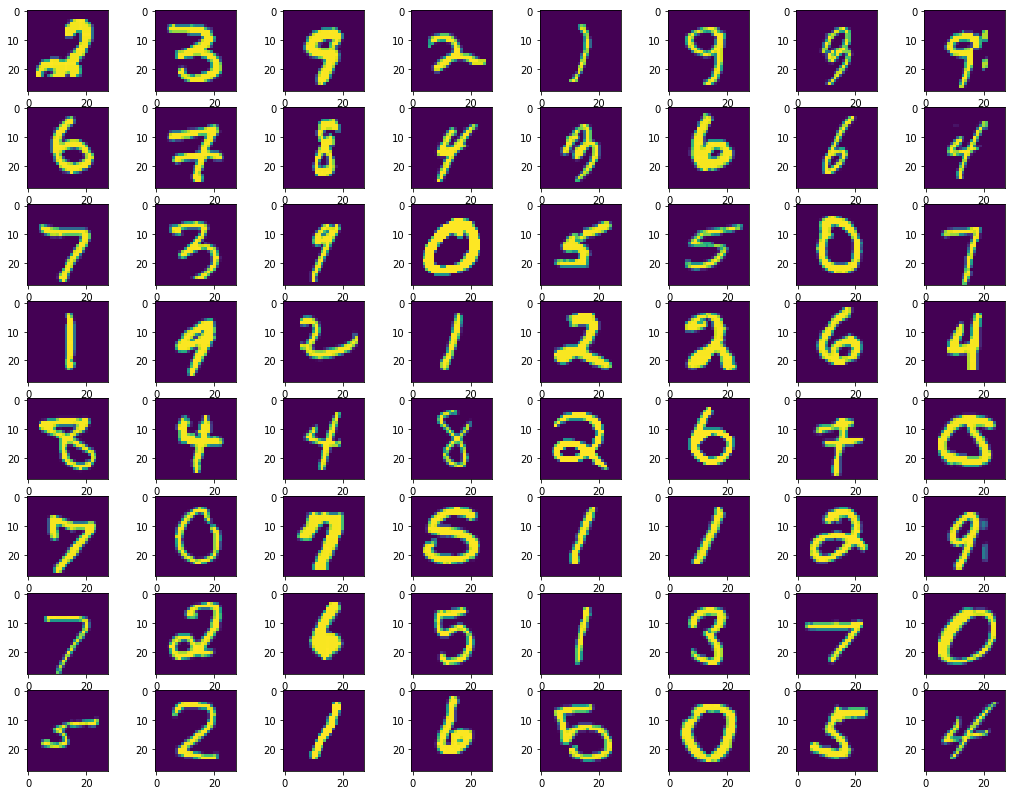

In [8]:
def _train_on_batches(discriminator, x_train, y_train, steps, batch_size, mixup=False, alpha=1.0, steps_per_print=5):
    if mixup:
        batch_size *= 2
    for s in range(steps):
        indexes = np.random.randint(0, x_train.shape[0], size=batch_size)
        image_batch = x_train[indexes, ...] 
        class_label = y_train[indexes, ...]
        if mixup:
            image_batch, class_label = _mixup_batch(image_batch, class_label, alpha)
        d_loss = discriminator.train_on_batch(image_batch, class_label)
        if s%steps_per_print == 0:
            _accuracy_on_batch(discriminator, image_batch, class_label)
            print(f'step {s} with loss {d_loss}')
    _plot_batch(image_batch)
            
(mnist_x, mnist_y), _ = load_mnist()            
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_16 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

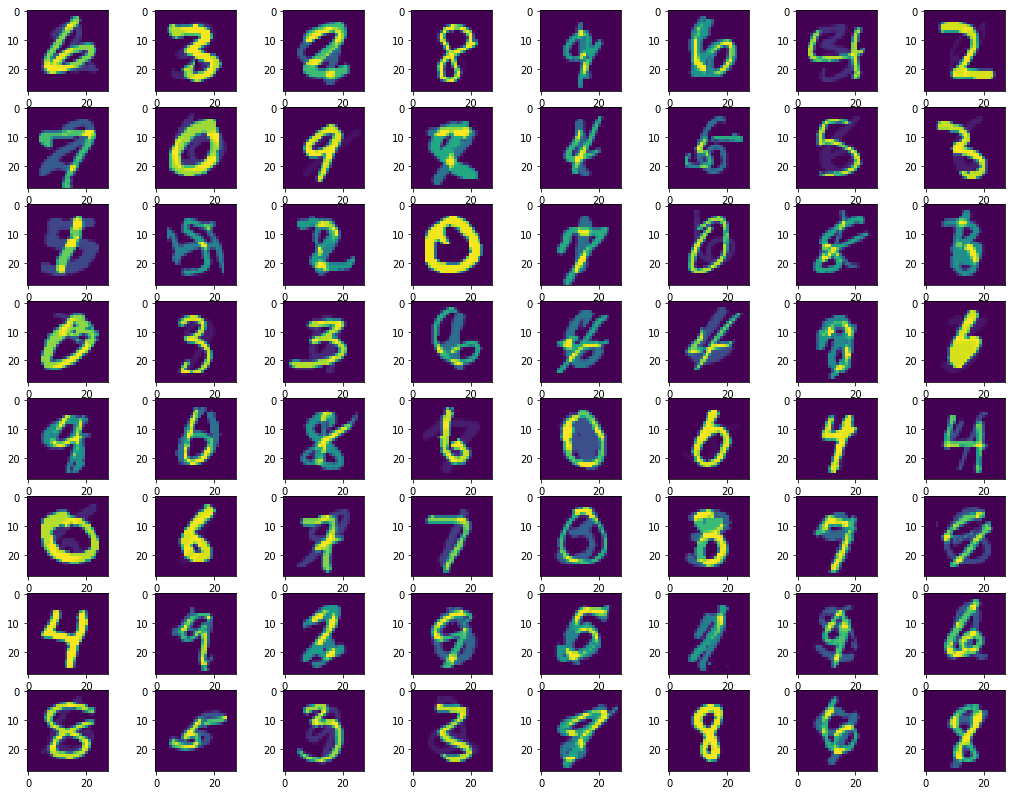

In [20]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_19 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

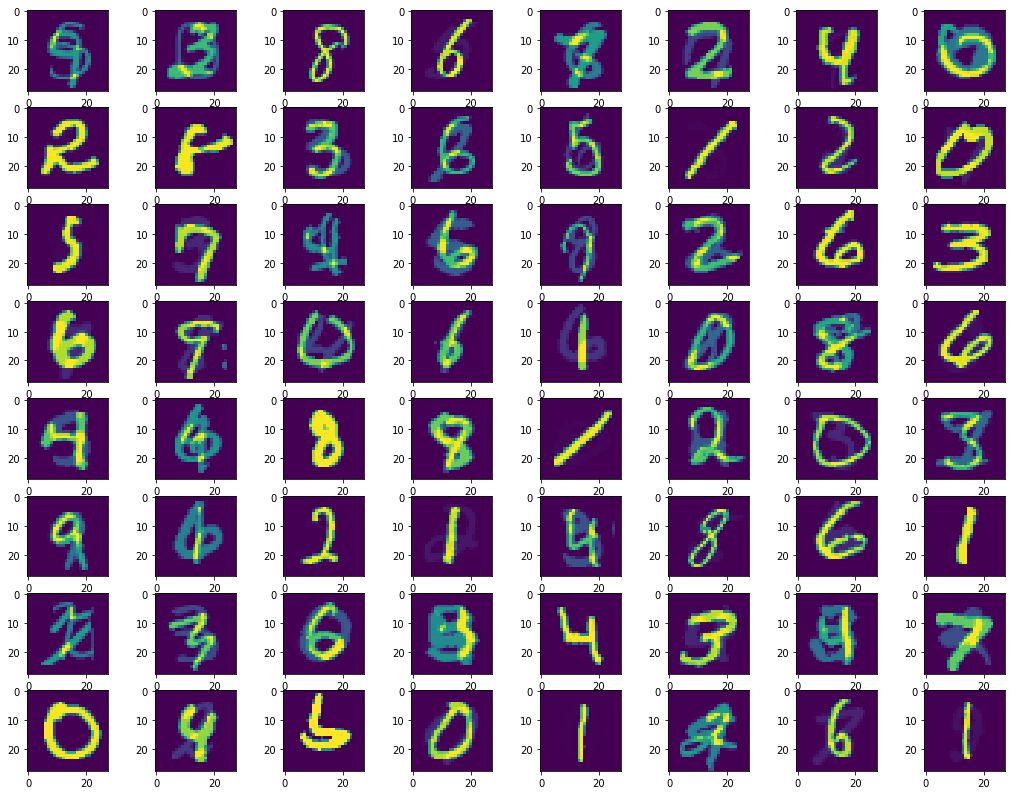

In [21]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_23 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

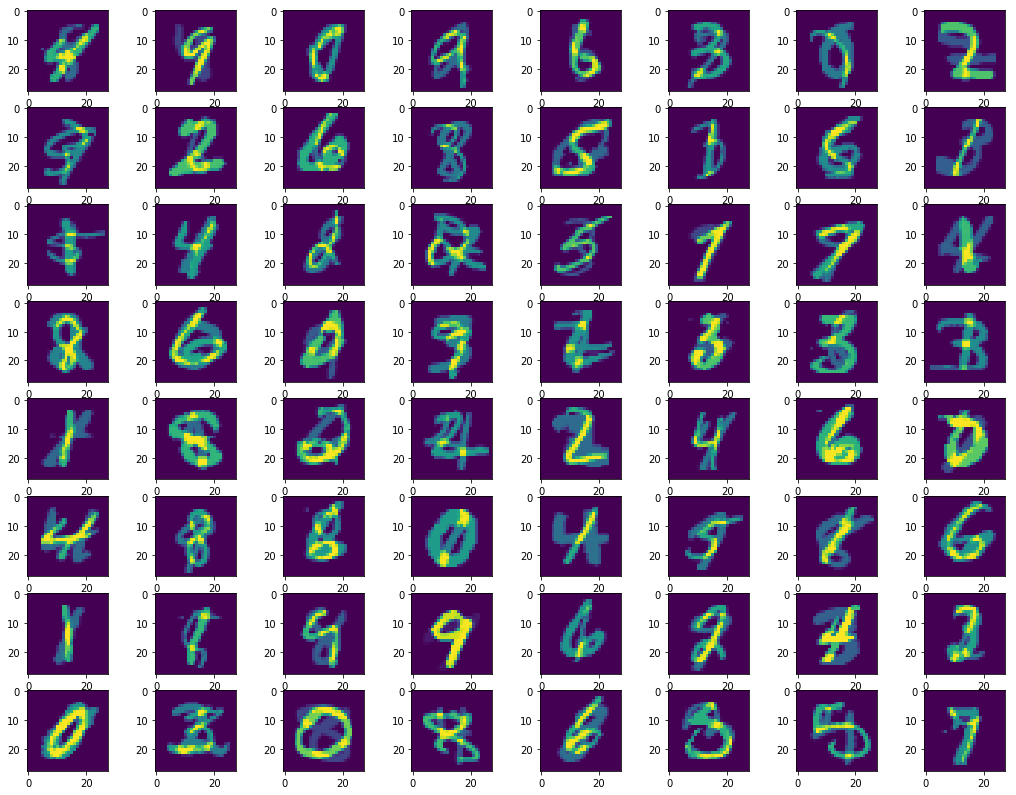

In [22]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=5.0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_25 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

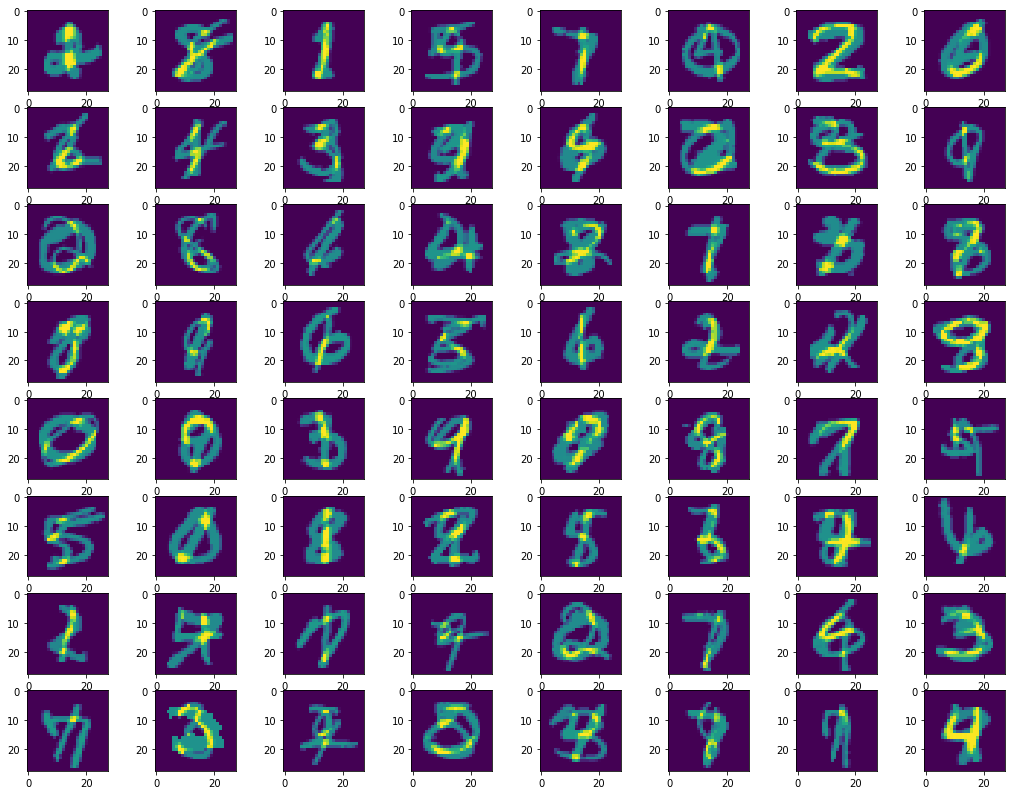

In [23]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 10, 64, mixup=True, alpha=500.0)

bounds: 0.0 1.0
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization_34 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_35 (Batc (None, 8, 8, 64)          256       
_____________________________________________________

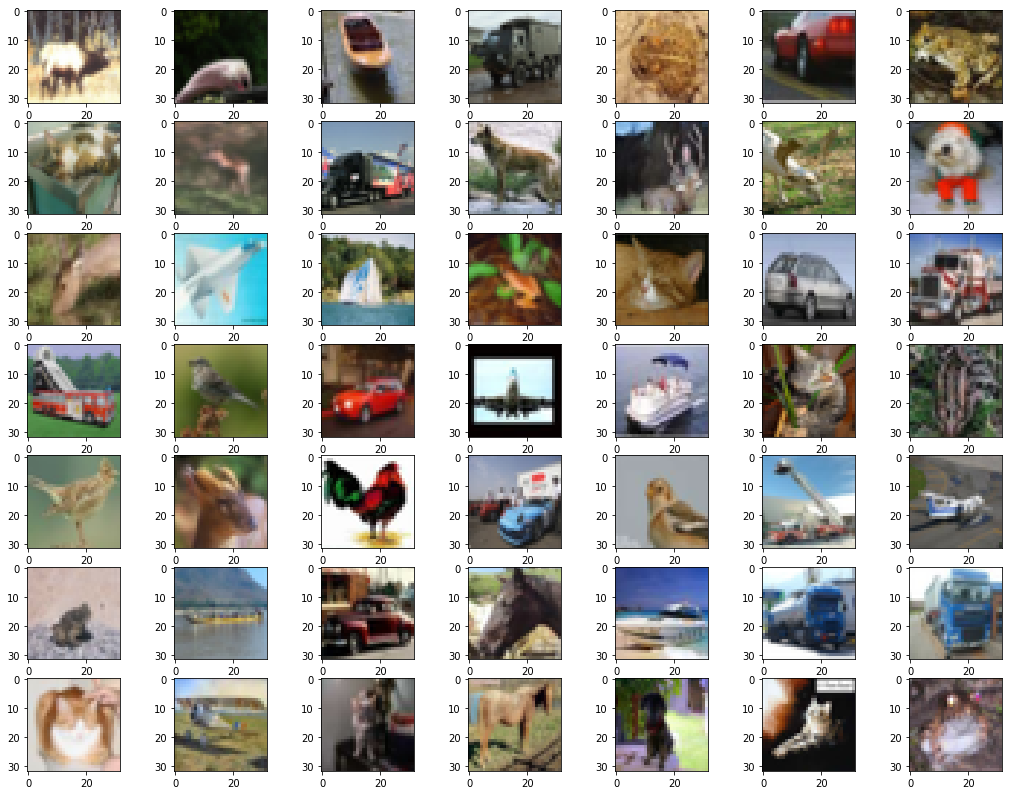

In [26]:
(cifar_x, cifar_y), _ = load_cifar()
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 200, 49, mixup=False, steps_per_print=400)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization_37 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_38 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

y true sum:['4.3', '4.1', '9.0', '5.3', '1.1', '5.1', '3.6', '1.8', '6.4', '8.3']. Accuracy: 42.86 pct (21 of 49).
y pred sum:['7.3', '5.2', '4.4', '3.1', '3.6', '2.8', '4.0', '3.3', '5.9', '9.5']
step 150 with loss 2.0636990070343018
y true sum:['6.5', '7.7', '3.1', '2.2', '6.0', '6.2', '3.2', '3.4', '6.5', '4.2']. Accuracy: 26.53 pct (13 of 49).
y pred sum:['2.6', '3.8', '2.1', '4.4', '2.5', '8.8', '7.0', '5.1', '2.3', '10.2']
step 155 with loss 2.0580315589904785
y true sum:['3.6', '4.6', '6.2', '5.3', '6.2', '4.1', '4.7', '6.5', '3.0', '4.8']. Accuracy: 22.45 pct (11 of 49).
y pred sum:['1.1', '2.9', '1.8', '5.8', '2.6', '10.9', '9.7', '6.6', '1.4', '6.3']
step 160 with loss 1.977010726928711
y true sum:['3.2', '3.3', '5.4', '9.4', '7.9', '3.8', '5.1', '1.6', '3.4', '5.9']. Accuracy: 34.69 pct (17 of 49).
y pred sum:['2.2', '9.4', '1.0', '5.3', '2.1', '5.6', '4.7', '5.8', '1.7', '11.1']
step 165 with loss 2.0599114894866943
y true sum:['2.8', '6.6', '2.8', '5.4', '6.0', '4.6', '6.8

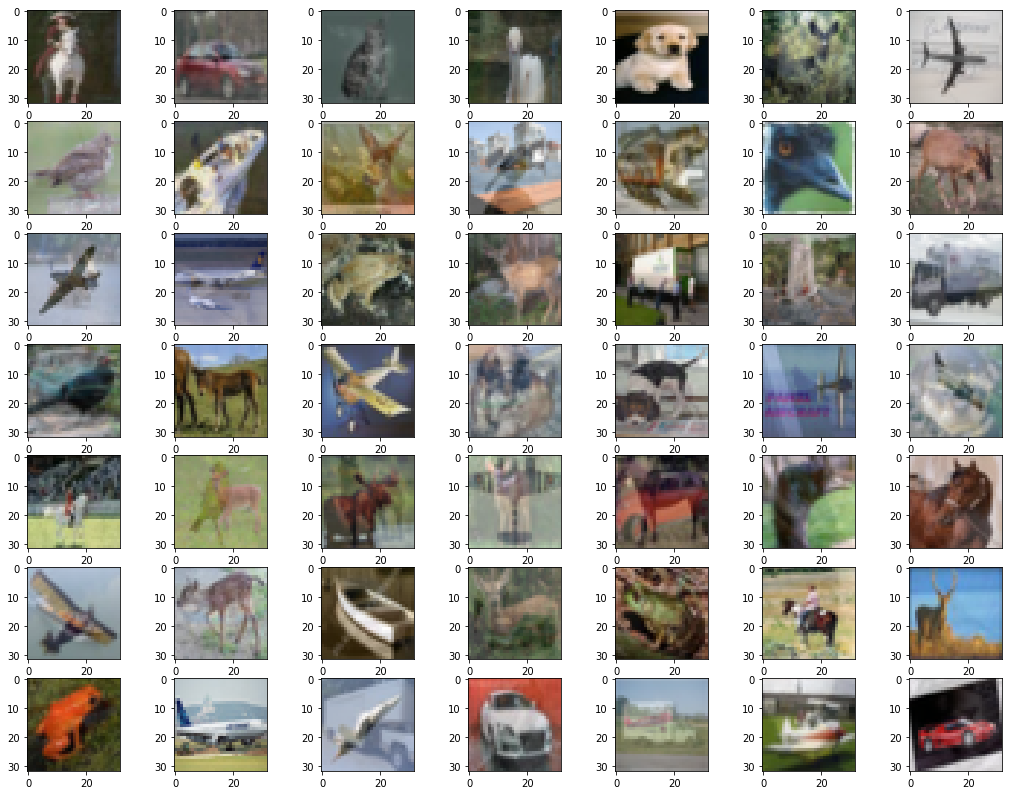

In [27]:
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)
_train_on_batches(cifar_discriminator, cifar_x, cifar_y,  200, 49, mixup=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization_40 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_41 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

y true sum:['2.1', '6.1', '2.8', '3.3', '6.3', '5.0', '3.8', '6.4', '4.4', '8.9']. Accuracy: 44.90 pct (22 of 49).
y pred sum:['5.9', '6.2', '5.3', '2.7', '5.8', '3.8', '4.5', '3.8', '3.3', '7.6']
step 150 with loss 1.8232896327972412
y true sum:['6.8', '4.5', '3.7', '4.3', '7.7', '6.1', '1.0', '5.2', '3.6', '6.1']. Accuracy: 42.86 pct (21 of 49).
y pred sum:['1.7', '6.0', '1.7', '5.5', '3.4', '7.2', '5.6', '10.5', '0.9', '6.5']
step 155 with loss 1.8116281032562256
y true sum:['4.0', '6.6', '5.2', '4.5', '4.6', '4.0', '7.2', '5.0', '4.9', '3.0']. Accuracy: 42.86 pct (21 of 49).
y pred sum:['3.2', '11.3', '2.1', '3.6', '3.7', '2.8', '5.5', '8.7', '3.0', '5.1']
step 160 with loss 1.6745665073394775
y true sum:['6.4', '5.5', '3.6', '5.4', '6.0', '4.1', '5.7', '3.3', '5.5', '3.5']. Accuracy: 34.69 pct (17 of 49).
y pred sum:['7.0', '4.7', '4.9', '3.7', '8.5', '3.0', '4.5', '3.3', '6.7', '2.5']
step 165 with loss 1.9490867853164673
y true sum:['3.7', '8.3', '7.4', '4.7', '4.7', '3.4', '2.6

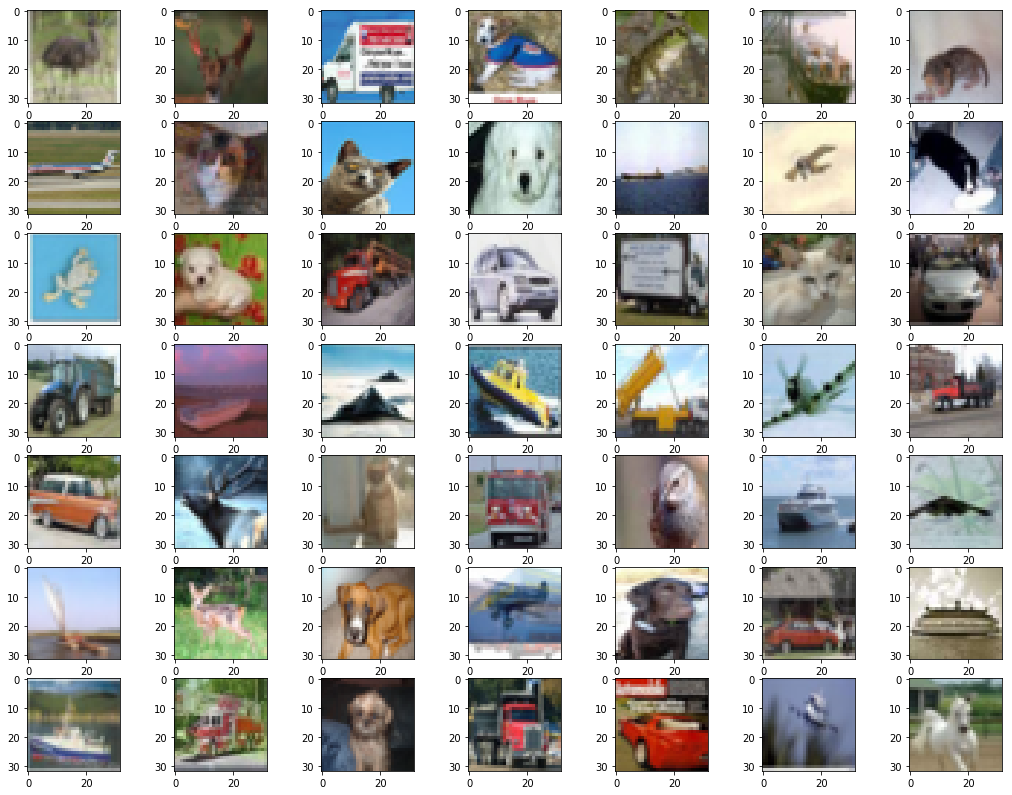

In [28]:
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 200, 49, mixup=True, alpha=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization_43 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
batch_normalization_44 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

y true sum:['6.7', '5.4', '2.8', '2.9', '6.7', '4.2', '3.3', '6.2', '7.0', '3.8']. Accuracy: 42.86 pct (21 of 49).
y pred sum:['5.4', '10.9', '1.9', '3.7', '2.6', '3.8', '3.5', '4.1', '6.8', '6.4']
step 150 with loss 1.7494093179702759
y true sum:['7.4', '5.6', '4.3', '3.8', '5.7', '4.7', '4.6', '3.2', '4.5', '5.1']. Accuracy: 40.82 pct (20 of 49).
y pred sum:['10.3', '4.7', '4.2', '2.7', '4.7', '3.0', '3.4', '2.2', '8.2', '5.6']
step 155 with loss 1.912491798400879
y true sum:['2.5', '4.0', '5.5', '6.5', '6.5', '4.7', '3.1', '8.1', '5.4', '2.7']. Accuracy: 26.53 pct (13 of 49).
y pred sum:['3.1', '3.2', '8.1', '3.3', '11.4', '3.3', '6.3', '3.1', '4.2', '2.9']
step 160 with loss 2.096954345703125
y true sum:['3.5', '6.3', '4.0', '8.4', '5.1', '4.3', '5.7', '4.5', '3.5', '3.6']. Accuracy: 24.49 pct (12 of 49).
y pred sum:['1.4', '14.3', '1.4', '2.3', '2.0', '2.5', '4.7', '4.4', '2.2', '13.8']
step 165 with loss 2.1114296913146973
y true sum:['4.9', '7.5', '4.1', '4.4', '1.7', '3.9', '3.

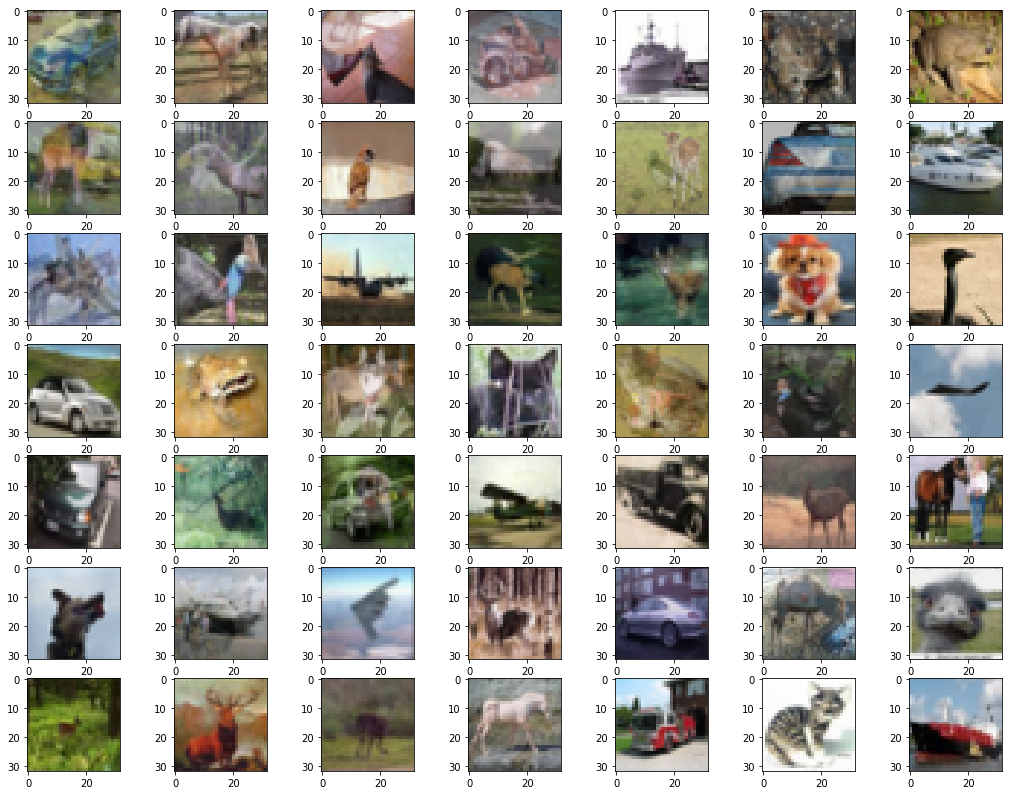

In [29]:
cifar_discriminator = build_discriminative_model((32, 32, 3), 10)
_train_on_batches(cifar_discriminator, cifar_x, cifar_y, 200, 49, mixup=True, alpha=0.5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

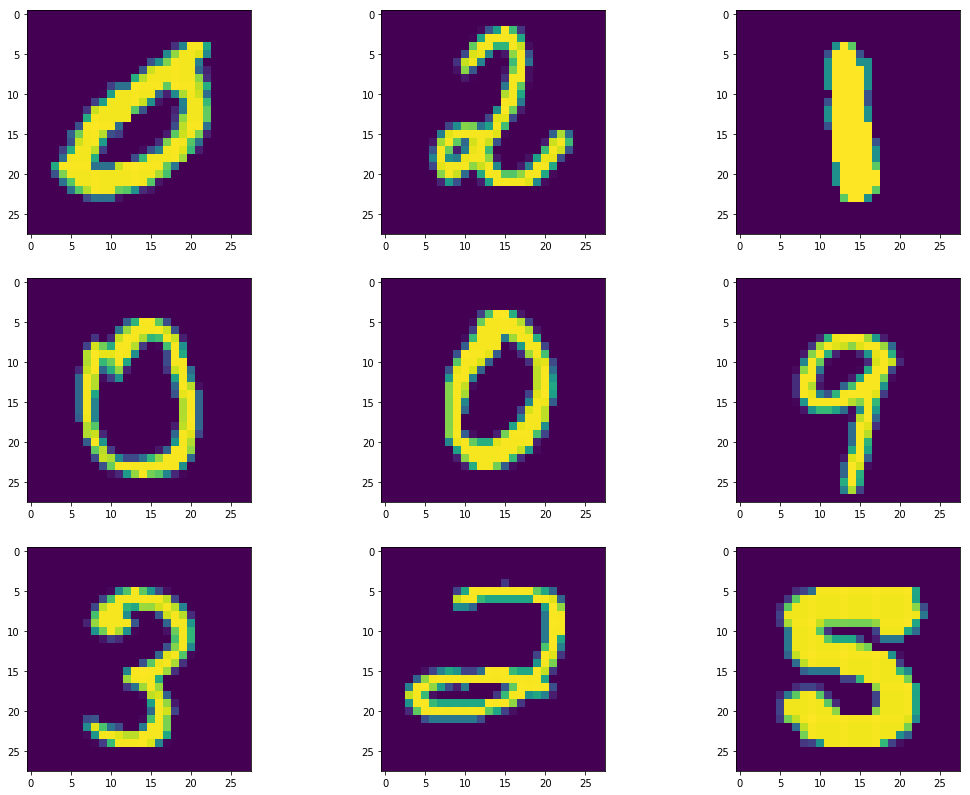

In [17]:
mnist_discriminator = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mnist_discriminator, mnist_x, mnist_y, 1000, 9, mixup=False, steps_per_print=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

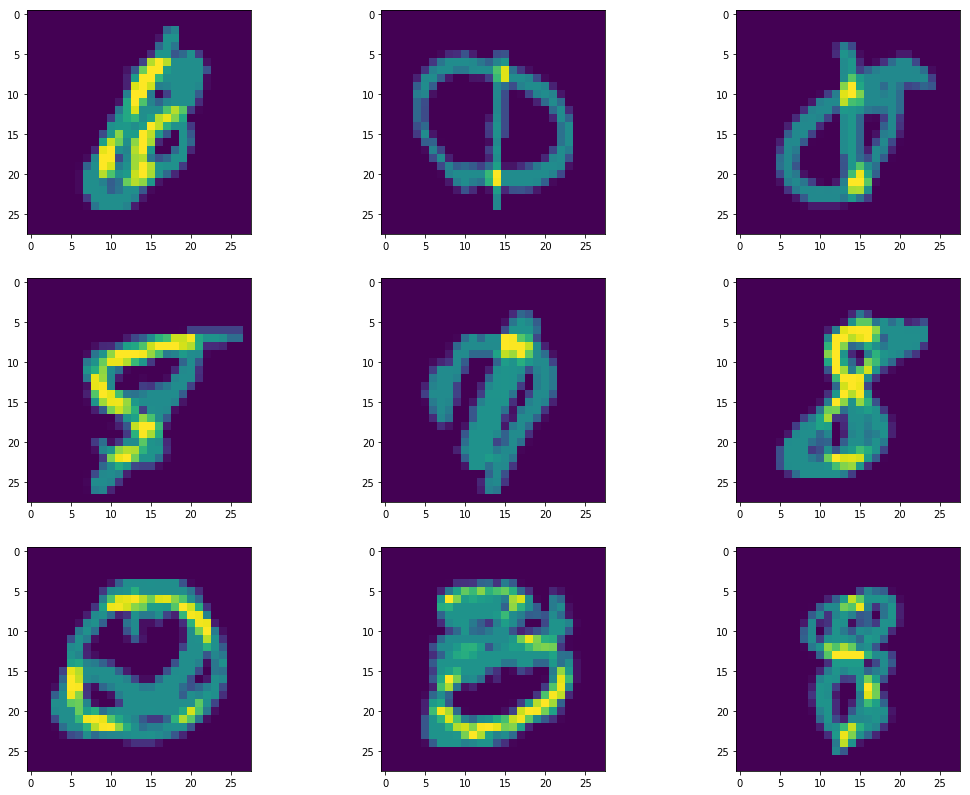

In [18]:
mixup_mnist_model = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mixup_mnist_model, mnist_x, mnist_y, 10000, 9, mixup=True, alpha=500.0, steps_per_print=1000)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       1280      
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          73792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

IndexError: index 5 is out of bounds for axis 0 with size 5

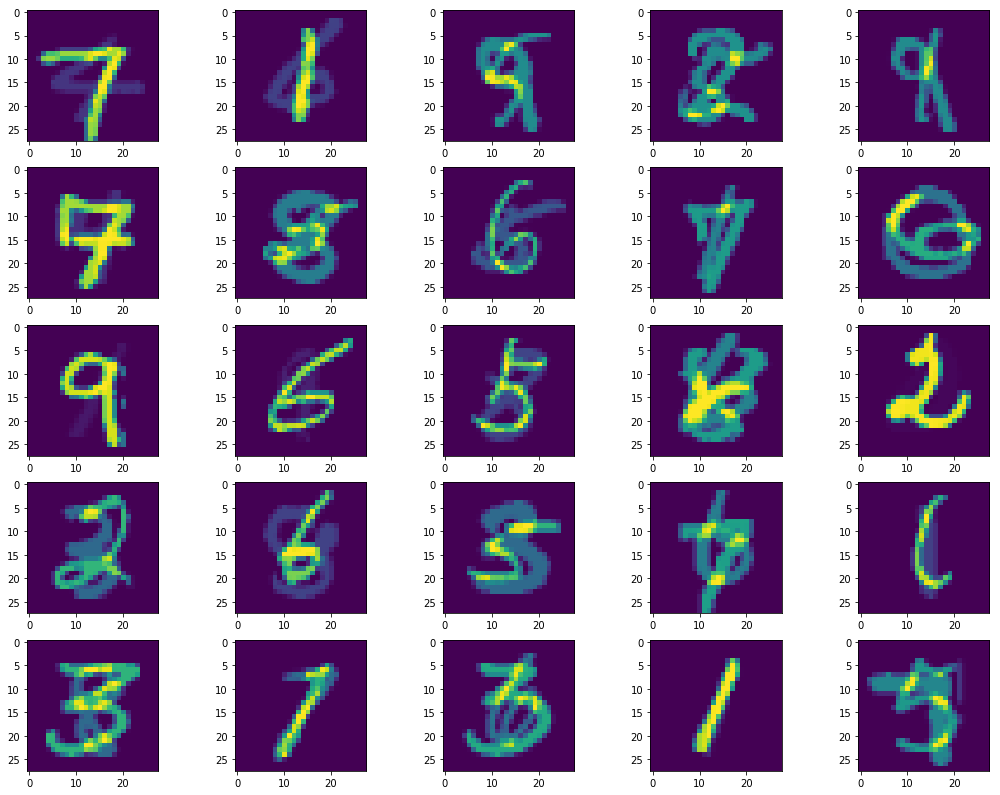

In [19]:
mixup_mnist_model = build_discriminative_model((28, 28, 1), 10)
_train_on_batches(mixup_mnist_model, mnist_x, mnist_y, 10000, 32, mixup=True, steps_per_print=500)